# Machine learning model for predicting price of a diamond

Capstone project for [DataTalksClub ML Zoomcamp](https://github.com/DataTalksClub/machine-learning-zoomcamp)

Target of this project is to utilize ML to predict, price of a diamonds.


## Getting data

As `diamonds` dataset is available in Seaborn, we utilize this 

In [2]:
import seaborn as sns

df = sns.load_dataset('diamonds', True)

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [4]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [5]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

No missing data presented in dataset.

Next, we explore categorical features of dataset.

In [6]:
df['cut'].unique()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

In [7]:
df['color'].unique()

['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']

In [8]:
df['clarity'].unique()

['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

Here is what does it all mean, from worst to best:

Cut - how well the diamond has been cut:
* Fair - Poor cut, less brilliance
* Good - Acceptable cut
* Very Good - Good brilliance
* Premium - High-quality cut
* Ideal - Best cut, maximum brilliance

Color - Measures how colorless the diamond is:
* J - Noticeable yellow tint
* I - Slight yellow tint
* H - Slightly noticeable color
* G - Near colorless
* F - Very little color
* E - Colorless
* D - Completely colorless 

Clarity - how free the diamond is from internal flaws (inclusions) and surface defects:
* I1 - Included, visible flaws
* SI2 - Slightly Included (noticeable)
* SI1 - Slightly Included (minor)
* VS2 - Very Slightly Included
* VS1 - Very Slightly Included (better)
* VVS2 - Very Very Slightly Included
* VVS1 - Extremely small inclusions
* IF - Internally Flawless

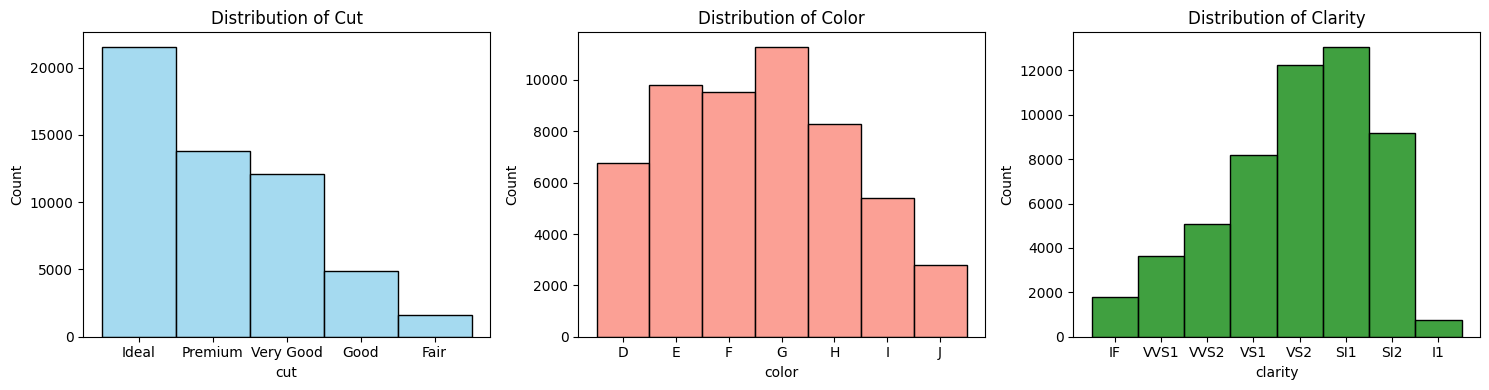

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df['cut'], bins=30, ax=ax[0], color='skyblue').set_title('Distribution of Cut')
sns.histplot(df['color'], bins=30, ax=ax[1], color='salmon').set_title('Distribution of Color')
sns.histplot(df['clarity'], bins=30, ax=ax[2], color='green').set_title('Distribution of Clarity')
plt.tight_layout()
plt.show()

Disblalanse is presented: there is a lot of diamond with `Ideal` cut, but best values of `clarity` and `color` is more rare.

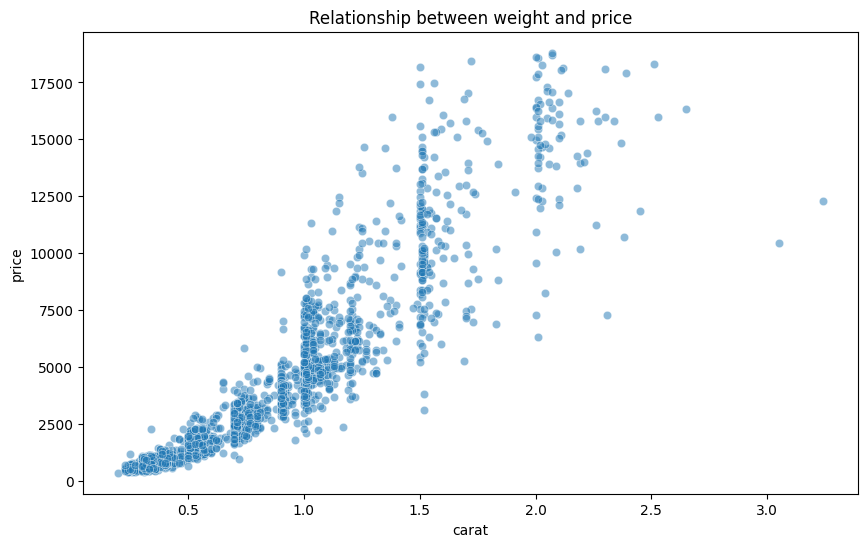

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(2000), x='carat', y='price', alpha=0.5)
plt.title('Relationship between weight and price')
plt.show()

#### Feature correlation

In [11]:
cut_map = {
    "Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5
}

color_map = {
    "J": 1, "I": 2, "H": 3, "G": 4, "F": 5, "E": 6, "D": 7
}

clarity_map = {
    "I1": 1, "SI2": 2, "SI1": 3, "VS2": 4, "VS1": 5,
    "VVS2": 6, "VVS1": 7, "IF": 8
}

df["cut_score"] = df["cut"].map(cut_map)
df["color_score"] = df["color"].map(color_map)
df["clarity_score"] = df["clarity"].map(clarity_map)

<Axes: >

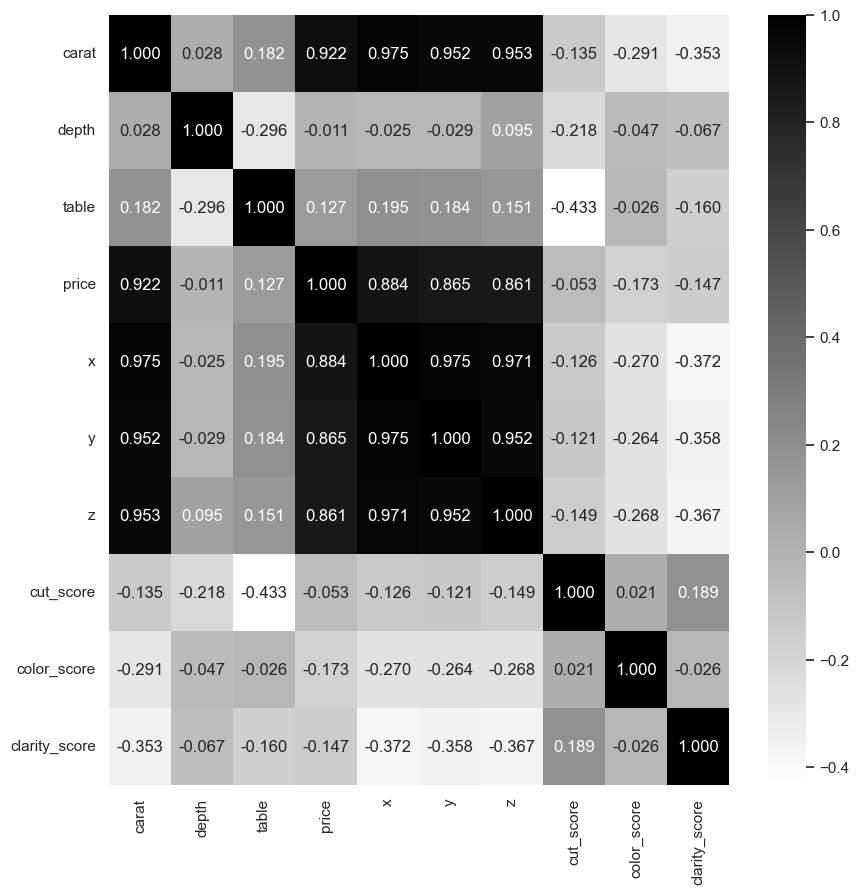

In [12]:
sns.set_theme(rc={'figure.figsize':(10,10)})
corr_col = [
    'carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut_score',
    'color_score', 'clarity_score',
]
sns.heatmap(df[corr_col].corr(), annot=True, fmt=".3f", cmap="binary")

Features with high correlation: `x`, `y`, `z` to `carat`.

This features will be removed from dataset.

## Model Training

### Preparing dataset

In [13]:
y = df['price']
X = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table']]

In [14]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

In [15]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
X_val_enc = dv.transform(X_val.to_dict(orient='records'))
X_test_enc = dv.transform(X_test.to_dict(orient='records'))

### Model Selection

In [16]:
import xgboost as xgb

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score

#### Linear model

In [17]:
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_enc, y_train)

best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")

Best Ridge alpha: 1.0


In [18]:
y_pred_ridge = best_ridge.predict(X_val_enc)
print(f"Tuned Ridge R2: {r2_score(y_val, y_pred_ridge):.4f}")

Tuned Ridge R2: 0.9175


#### RandomForestRegressor

In [19]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 9, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

rf_search.fit(X_train_enc, y_train)
best_rf = rf_search.best_estimator_

print(f"Best RandomForestRegressor params: {rf_search.best_params_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best RandomForestRegressor params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9}


In [20]:
y_pred_rf = best_rf.predict(X_val_enc)
print(f"Tuned RandomForestRegressor R2: {r2_score(y_val, y_pred_rf):.4f}")

Tuned RandomForestRegressor R2: 0.9640


#### eXtremeGradientBoosting

In [21]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 9, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_search = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train_enc, y_train)
best_xgb = xgb_search.best_estimator_

print(f"Best XGBoost params: {xgb_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost params: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [22]:
y_pred_tuned = best_xgb.predict(X_val_enc)
print(f"Tuned XGBoost R2: {r2_score(y_val, y_pred_tuned):.4f}")

Tuned XGBoost R2: 0.9801


## Final Model

From training, the best result was given by `xgboost` model with next parameters:

`subsample`: 0.9

`n_estimators`: 300

`max_depth`: 6

`learning_rate`: 0.05

`colsample_bytree`: 0.8

In [23]:
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    subsample=0.9,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    colsample_bytree=0.8,
)

final_model = final_model.fit(X_train_enc, y_train)

In [24]:
y_test_predicted = final_model.predict(X_test_enc)
print(f"Test R2 Score: {r2_score(y_test, y_test_predicted):.4f}")

Test R2 Score: 0.9804


### Model export

As we use One Hot Encoding, besides model we also have to export preprocessor.
For exporting preprocessor we will use builtin `pickle` module, and `json` for model as [suggested](https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html) by authors of the project

In [25]:
import pickle

MODEL_FILE = "model.json"
PREPROCESSOR_FILE = "preprocessor.pkl"

final_model.save_model(f'./models/{MODEL_FILE}')
with open(f'./models/{PREPROCESSOR_FILE}', 'wb') as f:
    pickle.dump({
        'vectorizer': dv,
        'features': list(list(dv.get_feature_names_out()))
    }, f, protocol=pickle.HIGHEST_PROTOCOL)